# Classification of short political articles collected from several news/opinions websites 
# ** By Y. Kostrov
***

***
# Overview
 In this project, I create a model that will classify political articles into three categories consisting
  "left", "right", and "center".

 During the analysis:
 1. I perform do explaratory data analysis.
 2. I prepare the data for training.
 3. I will split the data into training and testing sets.
 4. I explore three different embedings for text: Counting(Count Vectorizing), Term Frequency–Inverse Document Frequency (TFIDF), and Doc2Vec.
 5. I build a Naive Base model, Logistic Regression, Random Forest, and Deep Learing models.
 6. I compare the results of the beforementioned models to choose the better model based on the metric described below and retrain it on the whole data set.

# Business Problem
This project is centered around understanding the political view of the short article that we can find on the internet. It is, often, very hard to decide which policial inclanation the article has. The reader can take the text and use the model that comes out of this project to confirm the understanding of the political notion that the user has after reading with the prediction of the model.

# Metrics for Assessment
1. The primary metric for this project will be accuracy. Accuracy is the number of correct predictions divided by total number of predictions. Since we have pretty close number of articles in three different classes, accuracy should serve well as a primary metric. I will also look at the confusion matrix to keep an eye on the False Negatives and False Positives counts.
2. Based on part 1., I use precision and recall as two additional metrics. Recall is defined as a number of true positives divided by the number of total atual positives. Precision is defined as a number of true positives divied by the total number predited as positives.


# Data Description.
The data for this project was collected by me from the following websites: www.freebeacon.com, www.americanthinker.com, www.huffpost.com, www.slate.com, news.gallup.com, www.cbsnews.com. I put the articles into three category based on the political view of the hosting website. The categories are "left", "center", and "right". The data file has only two columns: "article" and "label".


# Import the packages

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from collections import defaultdict, Counter
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score
import gensim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SpatialDropout1D, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.preprocessing import LabelBinarizer

In [57]:
# read the data
df = pd.read_csv("data/test_2.csv")
df.head()

,article,label
0,Mental health professionals are no substitute ...,right
1,Merrick Garland's focus on school board meetin...,right
2,The president has yet to clarify what victory ...,right
3,"To hear President Joe Biden tell it, the Ameri...",right
4,The mainstream media's honeymoon with Presiden...,right


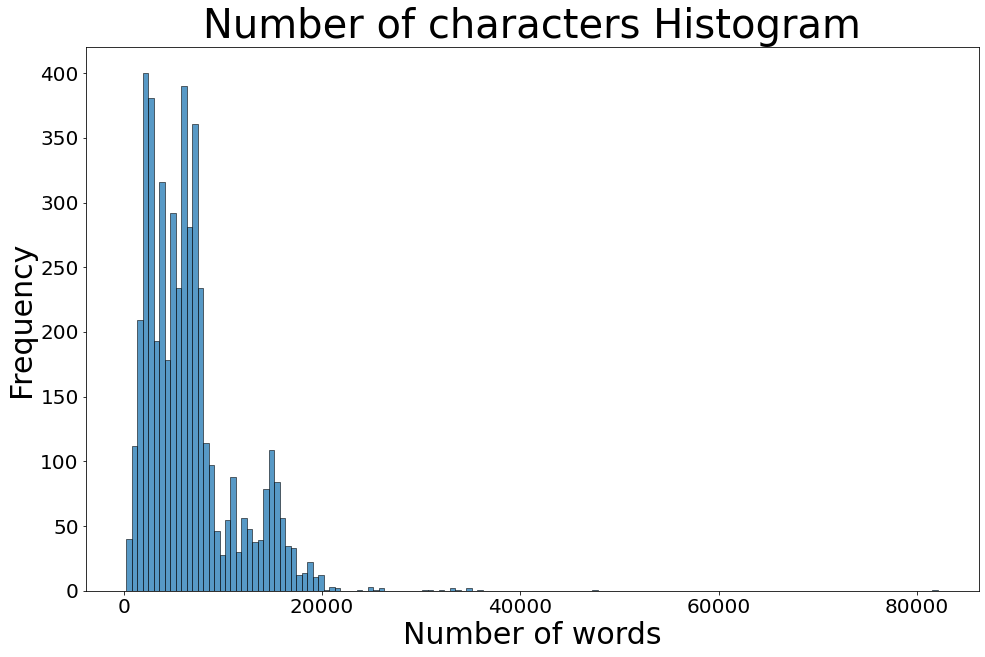

In [10]:
# Plot number of characters present in each sentence
plt.figure(figsize=(16,10))
sns.histplot(df.article.str.len())
plt.title("Number of characters Histogram", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Number of words', fontsize=30)
plt.xticks(fontsize=20)
plt.show()

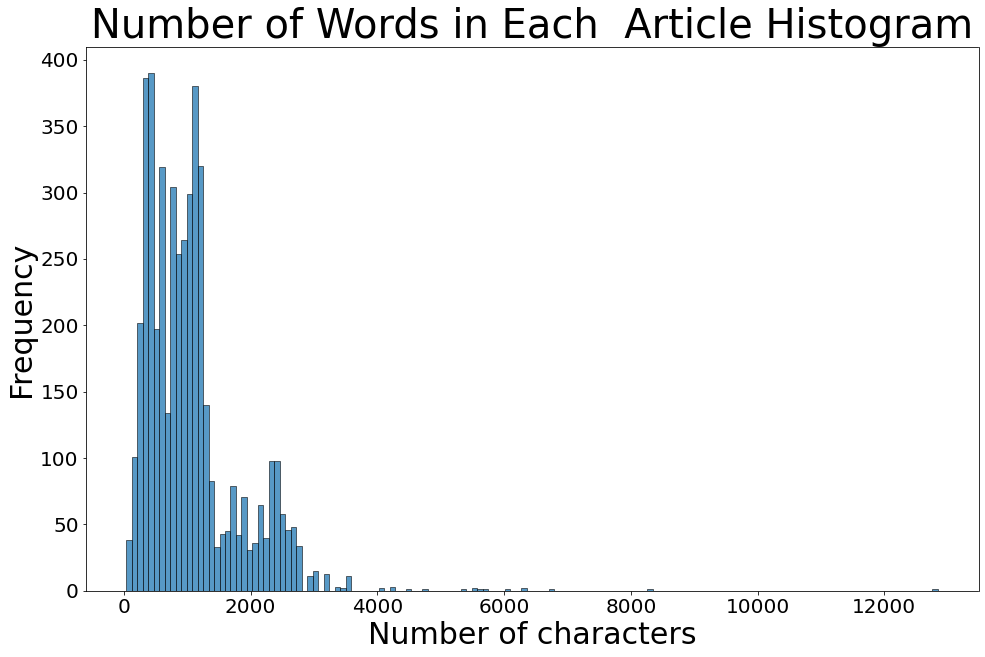

In [11]:
# plot number of words appearing in each article
plt.figure(figsize=(16,10))
sns.histplot(df.article.str.split().map(lambda x: len(x)))
plt.title("Number of Words in Each  Article Histogram", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Number of characters', fontsize=30)
plt.xticks(fontsize=20)
plt.show()

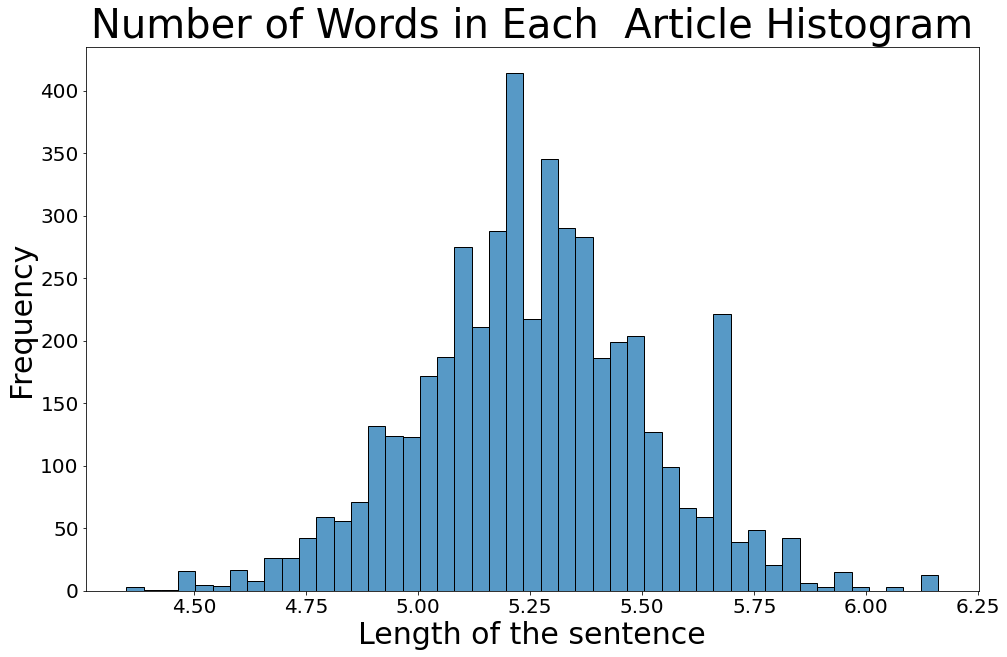

In [12]:
# plot average word length in each sentence.
plt.figure(figsize=(16,10))
sns.histplot(df.article.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)))
plt.title("Number of Words in Each  Article Histogram", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Length of the sentence', fontsize=30)
plt.xticks(fontsize=20)
plt.show()

In [13]:
# collect stopwords that are needed later
stop = set(stopwords.words('english'))

In [14]:
# build the corpus
corpus = [] 
article = df.article.str.split()
article = article.values.tolist()
corpus = [word for i in article for word in i]

In [15]:
# set up a dictionary
dictionary = defaultdict(int)

In [19]:
# fill in the dictionary
for word in corpus:
    if word in stop:
        dictionary[word] +=1

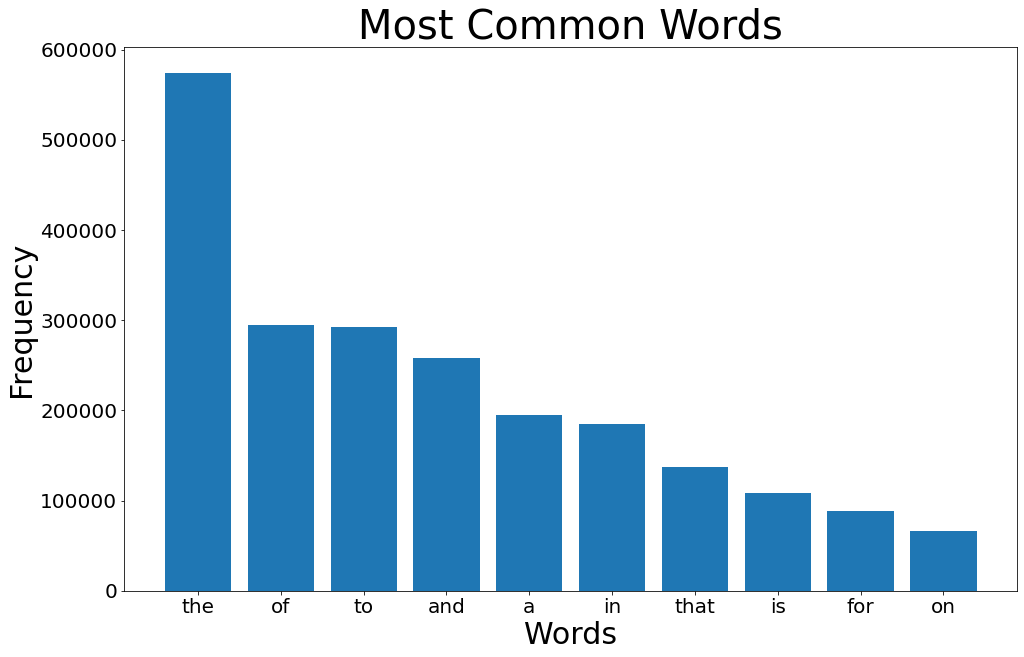

In [26]:
# check the most common words in dictionary
top=sorted(dictionary.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.figure(figsize=(16,10))
plt.bar(x,y)
plt.title("Most Common Words", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Words', fontsize=30)
plt.xticks(fontsize=20)
plt.show()

In [26]:
"""
we know which stopwords occur frequently in our text,
let’s inspect which words other than these stopwords
occur frequently.
"""

'\nwe know which stopwords occur frequently in our text,\nlet’s inspect which words other than these stopwords\noccur frequently.\n'

In [27]:
counter = Counter(corpus)
most = counter.most_common()

In [28]:
x,y = [],[]

In [30]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)

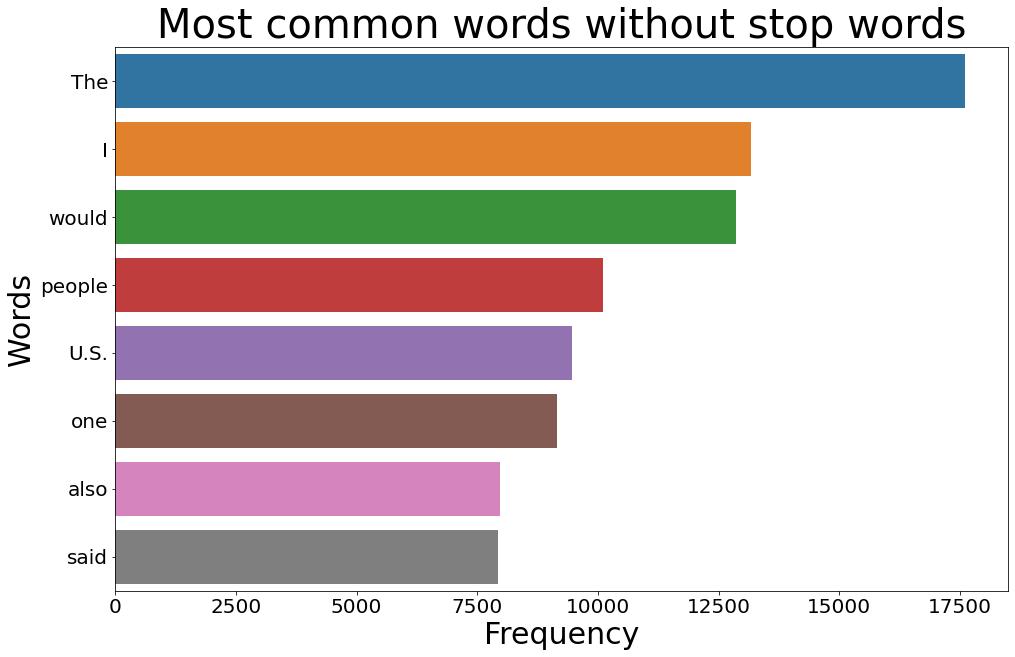

In [33]:

plt.figure(figsize=(16,10))
sns.barplot(x=y,y=x)
plt.title("Most common words without stop words", fontsize=40)
plt.ylabel('Words', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Frequency', fontsize=30)
plt.xticks(fontsize=20)
plt.show()

In [34]:
# size of the corpus
len(corpus)


4999681

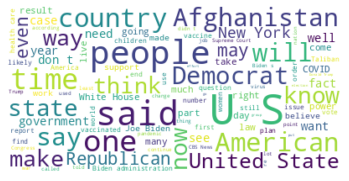

In [36]:
# building word cloud
text = " ".join(corpus)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
wordcloud.to_file("img/cloud.png")
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [37]:
# check the distribution of labels by classes
x_label = df.label.value_counts()
y_label = x_label.sort_index()

/Users/yevgeniykostrov/.local/share/virtualenvs/library-UZqeyXYS/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


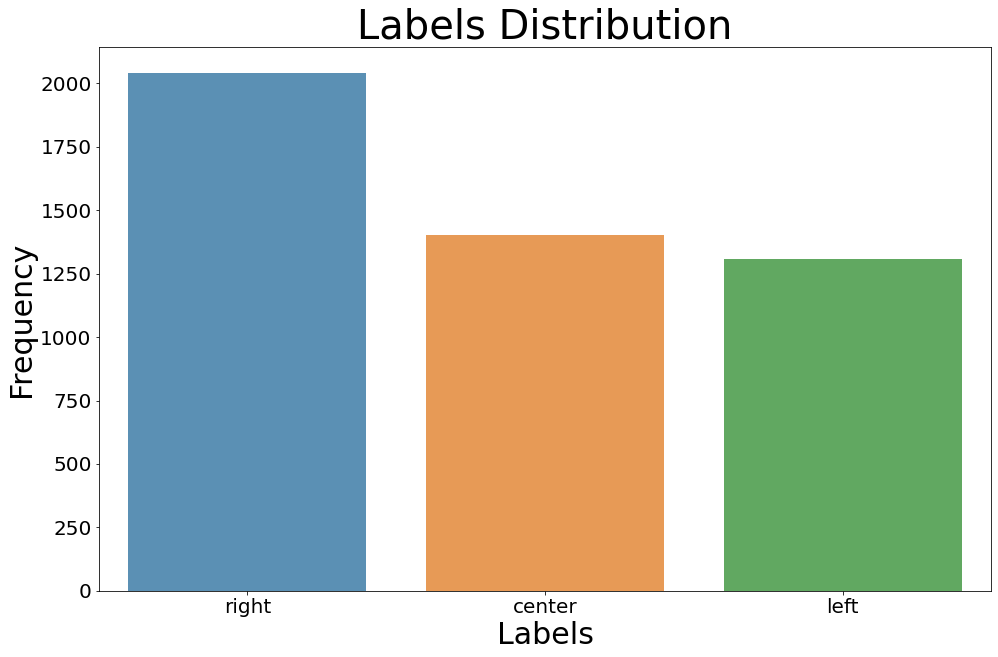

In [38]:
plt.figure(figsize=(16,10))
sns.barplot(x_label.index, x_label.values, alpha=0.8)
plt.title("Labels Distribution Bar Plot", fontsize=40)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Labels', fontsize=30)
plt.xticks(fontsize=20)
plt.show()

<AxesSubplot:title={'center':'Percentage of Labels Pie Chart'}, ylabel='label'>

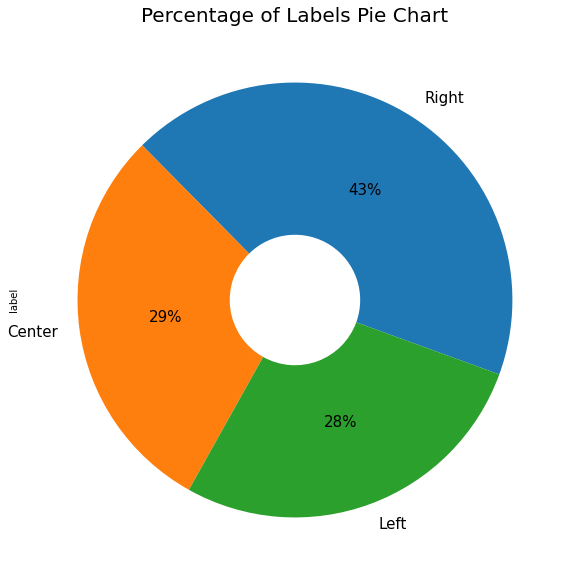

In [41]:
plt.figure(figsize=(16,10))
plt.title('Percentage of Labels Pie Chart', fontsize=20)
df.label.value_counts().plot(kind='pie', labels=['Right', 'Center', 'Left'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

In [43]:
# sentiment analysis
df['word_count'] = df.article.apply(lambda x: len(str(x).split()))
df['sentiment'] = df.article.apply(lambda x: TextBlob(x).sentiment.polarity)

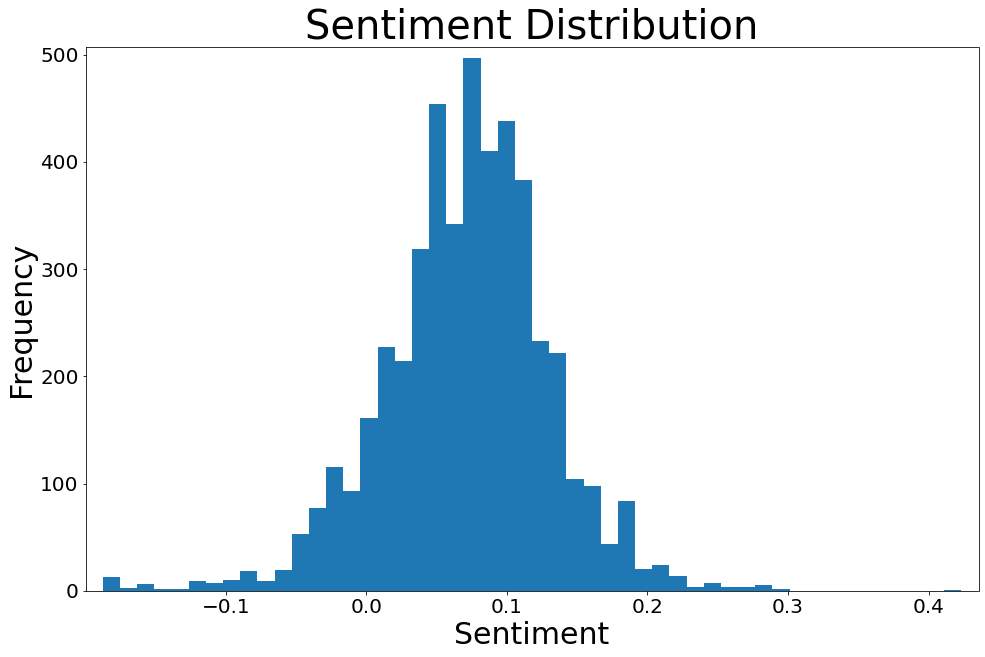

In [50]:
plt.figure(figsize=(16,10))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=30)
plt.xticks(fontsize=20)
plt.ylabel('Frequency', fontsize=30)
plt.yticks(fontsize=20)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=40)
plt.show()

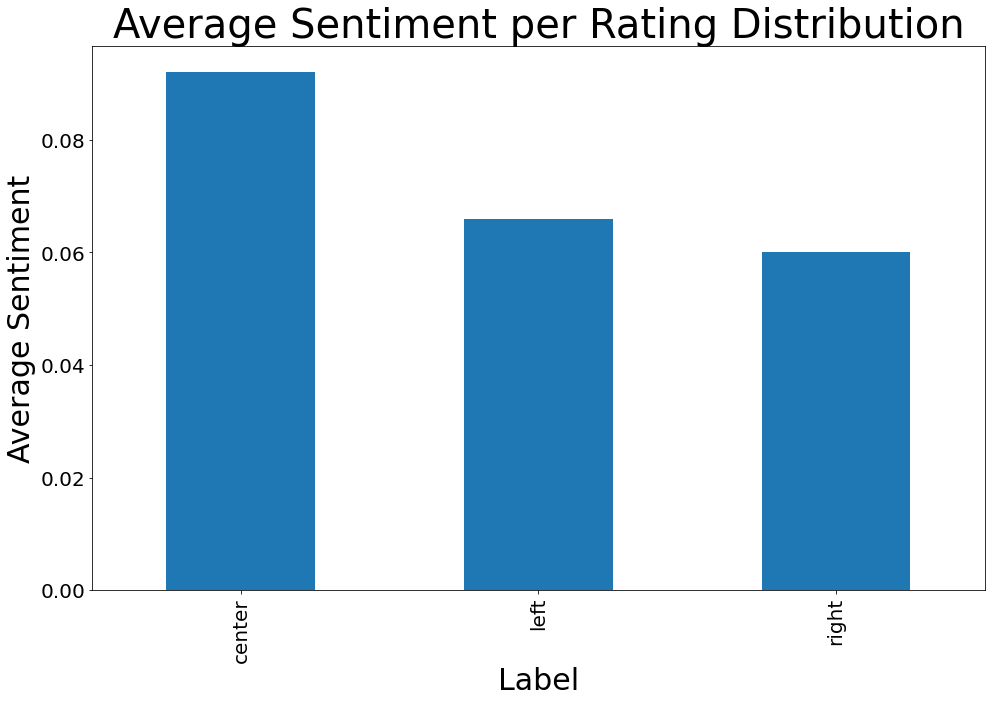

In [51]:
polarity_avg = df.groupby('label')['sentiment'].mean().plot(kind='bar', figsize=(16,10))
plt.xlabel('Label', fontsize=30)
plt.ylabel('Average Sentiment', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Sentiment per Rating Distribution', fontsize=40)
plt.show()

In [53]:
df['article_len'] = df.article.apply(lambda x:len(x))

/var/folders/c3/1vjm80gs2s1gq5k_8dh4rp1h0000gn/T/ipykernel_1638/531685463.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


<AxesSubplot:>

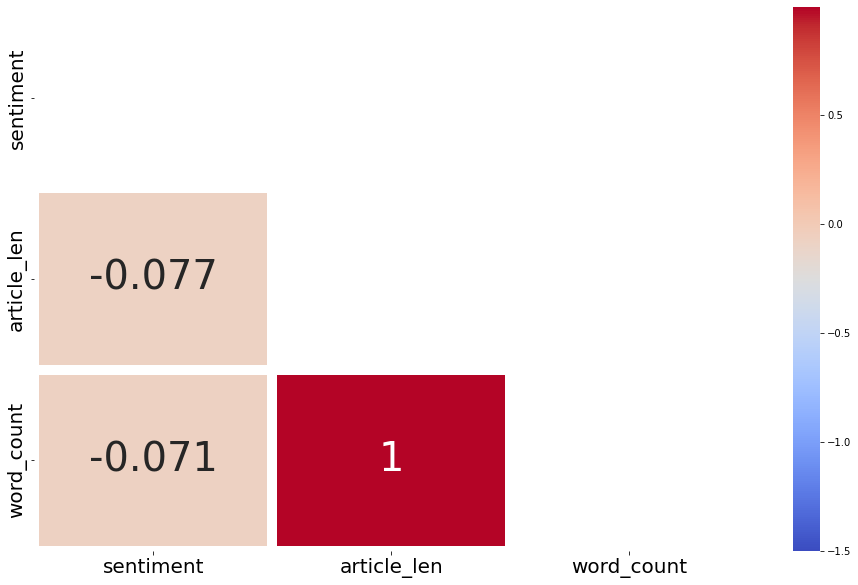

In [54]:
correlation = df[['label','sentiment', 'article_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [58]:
#free memory
del(df)

# In this section, I will build first models based on just counting technique (Tokenization)

In [67]:
# will start by "lemmatizing the articles"
lemmatizer = WordNetLemmatizer()

In [63]:
df = pd.read_csv('data/test_2.csv')

In [64]:
def modify(text):
    text = re.sub(r'\d+', '', string=text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = " ".join([i for i in tokens if not i in stop_words])
    text  = word_tokenize(text)
    text = " ".join([lemmatizer.lemmatize(word) for word in text])
    return text

In [65]:
a = modify("been had done languages cities mice")
a

'done language city mouse'

In [66]:
df['cleaned'] = df.article.apply(modify)

In [56]:
df.head()

,article,label,cleaned
0,Mental health professionals are no substitute ...,right,mental health professional substitute police c...
1,Merrick Garland's focus on school board meetin...,right,merrick garland focus school board meeting vio...
2,The president has yet to clarify what victory ...,right,president yet clarify victory pandemic look li...
3,"To hear President Joe Biden tell it, the Ameri...",right,hear president joe biden tell american evacuat...
4,The mainstream media's honeymoon with Presiden...,right,mainstream medias honeymoon president joe bide...


## Split the set into training and testing parts. Create pipeline with CountVectorizing

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned, df.label, test_size = 0.2, random_state = 42)

In [71]:
count_NB_clf = Pipeline([
    ('countVect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [59]:
count_NB_clf.fit(X_train, y_train)

Pipeline(steps=[('countVect', CountVectorizer()), ('clf', MultinomialNB())])

In [85]:
def print_scores(clf, X_test, y_true):
    y_preds = clf.predict(X_test)
    print("*"*50)
    print("confusion matrix:\n", confusion_matrix(y_true, y_preds), "\n")
    print("*"*50)
    print("accuracy:\n", accuracy_score(y_true, y_preds), "\n")
    print("*"*50)
    print("precision:\n", precision_score(y_true, y_preds, average='weighted'), "\n")
    print("*"*50)
    print("recall:\n", recall_score(y_true, y_preds, average='weighted'), "\n")
    

In [86]:
listModels = [MultinomialNB(), SGDClassifier(), RandomForestClassifier()]
listModels

[MultinomialNB(), SGDClassifier(), RandomForestClassifier()]

In [87]:
for clf in listModels:
    print(str(clf))
    pipe_clf = Pipeline([
        ('countVect', CountVectorizer()),
        ('clf', clf)
    ])
    pipe_clf.fit(X_train, y_train)
    print_scores(pipe_clf, X_test, y_test)
    

MultinomialNB()
**************************************************
confusion matrix:
 [[242  33   2]
 [ 12 248   9]
 [  0  13 392]] 

**************************************************
accuracy:
 0.9274447949526814 

**************************************************
precision:
 0.9303578968263958 

**************************************************
recall:
 0.9274447949526814 

SGDClassifier()
**************************************************
confusion matrix:
 [[275   2   0]
 [  1 257  11]
 [  1   2 402]] 

**************************************************
accuracy:
 0.982124079915878 

**************************************************
precision:
 0.9822192110373797 

**************************************************
recall:
 0.982124079915878 

RandomForestClassifier()
**************************************************
confusion matrix:
 [[276   1   0]
 [  1 264   4]
 [  0  15 390]] 

**************************************************
accuracy:
 0.9779179810725552 

************

In [ ]:
## Add TFIDF

In [71]:
for clf in listModels:
    print(f"Current Model: {str(clf)}")
    pipeLine = Pipeline([
        ('countVect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (str(clf), clf)])
    pipeLine.fit(X_train, y_train)
    print(f"For {str(clf)} we achieve")
    print_scores(pipeLine, X_test, y_test)

Current Model: MultinomialNB()
For MultinomialNB() we achieve
**************************************************
confusion matrix:
 [[208  17  52]
 [  9 136 124]
 [  0   0 405]] 

**************************************************
f1:
 0.7774500051536994 

**************************************************
precision:
 0.8274843386234304 

**************************************************
recall:
 0.7875920084121977 

Current Model: SGDClassifier()
For SGDClassifier() we achieve
**************************************************
confusion matrix:
 [[272   4   1]
 [  1 266   2]
 [  1   8 396]] 

**************************************************
f1:
 0.9821867171239588 

**************************************************
precision:
 0.9824621226250886 

**************************************************
recall:
 0.982124079915878 

Current Model: RandomForestClassifier()
For RandomForestClassifier() we achieve
**************************************************
confusion matrix:
 [[272  

# NEW SECTION 

In [72]:
def read_corpus(texts, tokens_only = False):
    for i in range(len(texts)):
        tokens = gensim.utils.simple_preprocess(texts.iloc[i])
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [73]:
train_corpus = list(read_corpus(X_train))

In [74]:
#print(train_corpus[:1])

In [75]:
test_corpus = list(read_corpus(X_test, tokens_only=True))
print(len(test_corpus))
#print(test_corpus[:1])

951


In [76]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [77]:
model.build_vocab(train_corpus)

In [78]:
print(f"Word 'penalty' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.")

Word 'penalty' appeared 222 times in the training corpus.


In [79]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [80]:
from tqdm import tqdm
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [81]:
cores = multiprocessing.cpu_count()

In [82]:
X_for_tr = [model.infer_vector(x.words) for x in train_corpus]

In [83]:
X_for_test = [model.infer_vector(x) for x in test_corpus]

In [84]:
logreg = SGDClassifier(n_jobs=-1)

In [85]:
logreg.fit(X_for_tr, y_train)

SGDClassifier(n_jobs=-1)

In [86]:
print_scores(logreg, X_for_test, y_test)

**************************************************
confusion matrix:
 [[220  55   2]
 [ 26 239   4]
 [  2  16 387]] 

**************************************************
f1:
 0.8906918222040994 

**************************************************
precision:
 0.8958285204262754 

**************************************************
recall:
 0.889589905362776 



In [98]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_for_tr, y_train)
print_scores(rf_clf, X_for_test, y_test)

**************************************************
confusion matrix:
 [[230  47   0]
 [  9 260   0]
 [  0  15 390]] 

**************************************************
f1:
 0.9263723051552067 

**************************************************
precision:
 0.9345678302849664 

**************************************************
recall:
 0.92534174553102 



In [101]:
X_for_test

[array([-1.5746337 , -2.889117  , -0.4906985 , -1.0891635 , -2.083009  ,
        -0.20201659, -1.5203261 ,  0.3385404 , -1.755877  , -0.4475641 ,
         1.6061265 ,  1.4560035 ,  0.0538206 ,  0.18952778,  0.18971388,
        -0.58391535,  2.740056  ,  1.2910365 , -0.9916704 , -1.8837543 ,
        -1.4343324 , -0.5878599 , -0.7347941 ,  0.23287103,  0.4824351 ,
         1.4226396 ,  0.89796907,  1.4421532 , -1.6687152 ,  0.4694513 ,
         0.26427183,  0.4153553 , -0.21455076,  1.3148556 ,  0.56902134,
         1.0060979 ,  0.78370285,  0.07464264, -0.13108611, -0.6197174 ,
         0.9545548 ,  2.8816414 , -1.8410556 , -1.832566  ,  3.5849056 ,
         1.836838  ,  0.13553849, -1.5734591 ,  3.4164698 , -0.27245066],
       dtype=float32),
 array([-1.51429832e+00, -1.75021160e+00,  6.33466363e-01,  1.82013226e+00,
        -2.07086945e+00, -2.93499064e+00, -2.05937433e+00, -1.92278679e-02,
        -2.57210374e+00,  3.53482389e+00, -2.83368659e+00,  1.07618642e+00,
        -1.6557679

# New Section

In [105]:
[X, y] = [df.article, df.label]
X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [106]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

In [107]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)

In [108]:
tokenizer.fit_on_texts(X_train.values)

In [109]:
word_index = tokenizer.word_index

In [110]:
print(f'Found {len(word_index)} unique tokens')

Found 44428 unique tokens


In [111]:
X_train_deep = tokenizer.texts_to_sequences(X_train.values)

In [112]:
X_test_deep = tokenizer.texts_to_sequences(X_test.values)

In [113]:
X_train_deep = pad_sequences(X_train_deep, maxlen=MAX_SEQUENCE_LENGTH)
X_test_deep = pad_sequences(X_test_deep, maxlen=MAX_SEQUENCE_LENGTH)
print(f'SHape of data tensor: {X_train_deep.shape}')

SHape of data tensor: (3800, 250)


In [114]:
lb = LabelBinarizer()
y_train_deep = lb.fit_transform(y_train.values)
y_train_deep[1]

array([0, 0, 1])

In [115]:
y_test_deep = lb.transform(y_test.values)
y_test_deep[1]

array([0, 0, 1])

In [116]:
y_train_deep

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [117]:
def buildModel():
    optimizer = tf.keras.optimizers.Adam()
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_deep.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
    #model.add(Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

In [118]:
X_train_deep.shape, y_train.shape

((3800, 250), (3800,))

In [119]:
epochs = 10
batch_size = 48
model = buildModel()
history = model.fit(X_train_deep, y_train_deep, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

2021-11-06 13:35:56.975058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
64/64 [==============================] - 182s 3s/step - loss: 0.8507 - accuracy: 0.6783 - val_loss: 0.5233 - val_accuracy: 0.6895
Epoch 2/10
64/64 [==============================] - 160s 3s/step - loss: 0.2471 - accuracy: 0.8905 - val_loss: 0.1168 - val_accuracy: 0.9632
Epoch 3/10
64/64 [==============================] - 138s 2s/step - loss: 0.0455 - accuracy: 0.9872 - val_loss: 0.0920 - val_accuracy: 0.9684
Epoch 4/10
64/64 [==============================] - 138s 2s/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.0763 - val_accuracy: 0.9724
Epoch 5/10
64/64 [==============================] - 124s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.9750
Epoch 6/10
64/64 [==============================] - 117s 2s/step - loss: 7.1319e-04 - accuracy: 1.0000 - val_loss: 0.0682 - val_accuracy: 0.9789
Epoch 7/10
64/64 [==============================] - 115s 2s/step - loss: 3.8121e-04 - accuracy: 1.0000 - val_loss: 0.0715 - val_accuracy: 0.9763
Epoch

In [120]:
accr = model.evaluate(X_test_deep, y_test_deep)
print(f'Test set \n Loss {accr[0]:0.3f} Accuracy {accr[1]:0.3f}')

30/30 [==============================] - 2s 64ms/step - loss: 0.1307 - accuracy: 0.9653
Test set 
 Loss 0.131 Accuracy 0.965


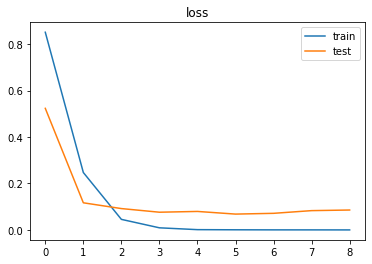

In [121]:
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

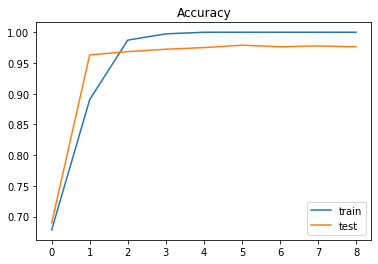

In [122]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [123]:
y_preds = model.predict(X_test_deep)

In [124]:
y_preds = model.predict_classes(X_test_deep)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [125]:
y_preds = np.argmax(model.predict(X_test_deep), axis=1)

In [126]:
y_preds = [lb.classes_[i] for i in y_preds]

In [127]:
from sklearn.metrics import accuracy_score

In [128]:
print(confusion_matrix(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds,average=None).mean())
print(recall_score(y_test, y_preds,average=None).mean())

[[262  12   3]
 [  6 259   4]
 [  0   8 397]]
0.9652996845425867
0.96286687327054
0.9629735226139732


In [129]:
X = df.article
y = df.label
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(X)
lb = LabelBinarizer()
lb.fit(y)
def preprocess(X,y):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    y = lb.transform(y)
    return X, y
X, y = preprocess(X, y)
print(X.shape, y.shape)


(4751, 250) (4751, 3)


In [130]:
epochs = 5
batch_size = 128
model = buildModel()
history = model.fit(X, y, epochs=epochs, batch_size=batch_size,callbacks=[EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)])

Epoch 1/5
38/38 [==============================] - 140s 4s/step - loss: 0.7507 - accuracy: 0.6409
Epoch 2/5
38/38 [==============================] - 135s 4s/step - loss: 0.2261 - accuracy: 0.9451
Epoch 3/5
38/38 [==============================] - 125s 3s/step - loss: 0.0529 - accuracy: 0.9823
Epoch 4/5
38/38 [==============================] - 114s 3s/step - loss: 0.0161 - accuracy: 0.9966
Epoch 5/5
38/38 [==============================] - 107s 3s/step - loss: 0.0065 - accuracy: 0.9985


In [93]:
accr = model.evaluate(X, y)
print(f'Test set \n Loss {accr[0]:0.3f} Accuracy {accr[1]:0.3f}')

110/110 [==============================] - 6s 51ms/step - loss: 0.0030 - accuracy: 1.0000
Test set 
 Loss 0.003 Accuracy 1.000


In [94]:
tr = """
Members of the Squad did not respond when asked to comment on the historic Virginia lieutenant governor election of Winsome Sears, who will be the first woman Lt. Gov., the first Black woman elected statewide, and the first naturalized citizen to hold the position.

Fox News reached out to the press secretaries of Rep. Alexandria Ocasio-Cortez, Rashida Tlaib, Cori Bush and Ayanna Pressley, as well as Ilhan Omar's chief of staff, requesting comment on Sears’ win early Wednesday. None of the spokespeople responded to the requests by close of business Wednesday. 
"I'm telling you that what you are looking at is the American dream," Sears, a Republican, said early Wednesday morning during her victory speech. 
placeholder

WINSOME SEARS SAYS SHE WOULD DIE FOR AMERICA, STARTS 'USA' CHANT DURING VICTORY SPEECH: 'AMERICAN DREAM'

Sears, a Marine Corps veteran, immigrated to the United States from Jamaica as a child, and previously served a single term in Virginia’s House of Delegates from 2002 to 2004. 

Her 2021 run for lieutenant governor marked her return to politics after her term in the House of Delegates. 
Former Republican Delegate Winsome Sears celebrates winning the race for Lt. Governor of Virginia .(REUTERS/ Jonathan Ernst)

Former Republican Delegate Winsome Sears celebrates winning the race for Lt. Governor of Virginia .(REUTERS/ Jonathan Ernst) (REUTERS/ Jonathan Ernst)

"In case you haven't noticed, I am Black. And I have been Black all my life, but that's not what this is about," she continued. 

"What we are going to do now is be about the business of the Commonwealth," she said. "We have things to tend to. We are going to fully fund our historically Black colleges and universities. We’re going to have safer neighborhoods, safer communities, and our children are going to get a good education."

WINSOME SEARS, VIRGINIA GOP LIEUTENANT GOVERNOR CANDIDATE: WHAT TO KNOW
Former Republican Delegate Winsome Sears celebrates winning the race for Lt. Governor of Virginia as she introduces Republican candidate for Governor Glenn Youngkin during an election night party in Chantilly Virginia, U.S., November 3, 2021. REUTERS/ Jonathan Ernst

Former Republican Delegate Winsome Sears celebrates winning the race for Lt. Governor of Virginia as she introduces Republican candidate for Governor Glenn Youngkin during an election night party in Chantilly Virginia, U.S., November 3, 2021. REUTERS/ Jonathan Ernst (REUTERS/ Jonathan Ernst)

Fox News examined the Twitter feeds belonging to the Squad members and also found no tweets concerning Sears’ historic win, despite their history of supporting other women and women of color running for office. 
"""

In [95]:
y =['right']

In [96]:
X, y = preprocess([tr], y)

In [97]:
pred = np.argmax(model.predict(X), axis=1)[0]
pred

1

In [98]:
lb.classes_[pred]

'left'